In [1]:
import pandas as pd
import os
import aioinflux
import calendar

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline  

In [2]:
kwargs = {
    'host': '192.168.2.131',
    'port': os.getenv('INFLUXDB_PORT'),
    'username': os.getenv('INFLUXDB_USER'),
    'password': os.getenv('INFLUXDB_PASS'),
    'db': os.getenv('INFLUXDB_DB'),
    'output': 'dataframe'
}

measurement = 'gas_prices_euro'
async with aioinflux.InfluxDBClient(**kwargs) as ifclient:
    df = await ifclient.query(f"""
        SELECT * FROM {measurement}
    """)

In [3]:
brand = 'Star'
gas_type = 'e5'
metric = df[df['brand']==brand][gas_type]

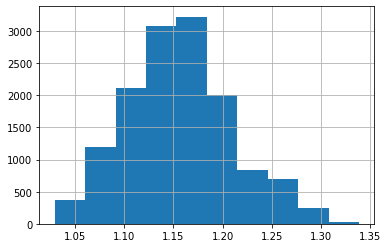

In [4]:
metric.hist()

In [5]:
def plot_gas_prices(df_quantiles, index=None, title_post_fix=''):
    if index is None:
        index = df_quantiles.index
    fig, ax = plt.subplots()
    ax.fill_between(
        index, df_quantiles[0.5], df_quantiles[0.95], alpha=0.4, edgecolor='black', facecolor='blue'
    )
    ax.fill_between(
        index, df_quantiles[0.05], df_quantiles[0.5], alpha=0.4, edgecolor='black', facecolor='blue'
    )
    
    # highlight extrema
    ax.plot(df_quantiles[0.5].idxmin(), df_quantiles[0.5].min(), '*', color='green')
    ax.plot(df_quantiles[0.5].idxmax(), df_quantiles[0.5].max(), '*', color='red')
    print(f'argmin: {df_quantiles[0.5].idxmin()}')
    print(f'argmax: {df_quantiles[0.5].idxmax()}')

    # grid
    plt.rc('grid', linestyle="dotted", color='black')
    plt.grid(True)

    # set labels
    plt.title(f'Gas Price ({gas_type.capitalize()}) {title_post_fix}')
    plt.ylabel(f'Gas Price (in Euro)');

    return fig, ax

In [6]:
def compute_quantiles(metric, grouper):
    df = metric.groupby(grouper).quantile([0.05, 0.5, 0.95])
    return df.reset_index().pivot(index='level_0', columns='level_1', values=[gas_type])

In [23]:
def adjust_trend(metric, grouper):
    trend = metric.groupby(grouper).median()
    df=pd.merge(
        metric.to_frame().reset_index(), trend,
        left_on=metric.groupby(grouper).apply(lambda x: pd.Series(x.name,x.index)).values,
        right_on=trend.index.values,
        how='left',
        suffixes=('', '_trend')
    ).set_index('index')
    metric_without_trend = df[gas_type]-df[f'{gas_type}_trend']
    metric_without_trend.name = metric.name
    metric_without_trend.index.name = metric.index.name
    return metric_without_trend

## Gas Prices per Week

In [24]:
week_grouper = pd.Grouper(freq='W-MON')
df_week_summary = compute_quantiles(metric, week_grouper)

argmin: 2020-04-27 00:00:00+00:00
argmax: 2020-04-06 00:00:00+00:00


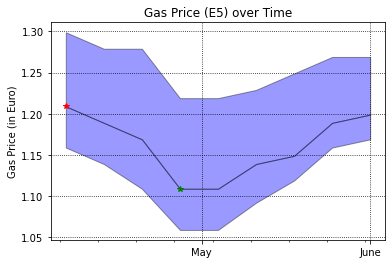

In [25]:
fig, ax = plot_gas_prices(df_week_summary[gas_type], title_post_fix='over Time')
# format the ticks
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7));

#plt.savefig(f'{metric}.png', dpi=300)

## Gas Prices per Weekday

In [26]:
weekday_map = dict(enumerate(calendar.day_name))

argmin: 4
argmax: 0


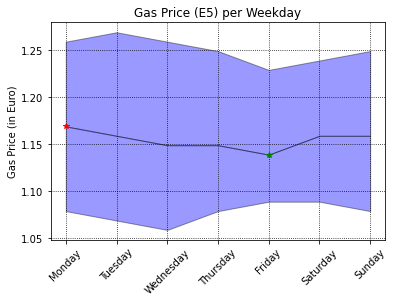

In [27]:
df_weekday_summary = compute_quantiles(metric, metric.index.dayofweek)
fig, ax = plot_gas_prices(
    df_weekday_summary[gas_type],
    index=df_weekday_summary.index.map(weekday_map),
    title_post_fix='per Weekday'
)
# format the ticks
plt.xticks(rotation=45);

argmin: 2
argmax: 0


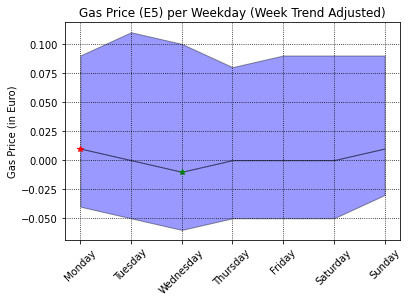

In [28]:
metric_without_weekly_trend = adjust_trend(metric, week_grouper)
df_weekday_summary = compute_quantiles(metric_without_weekly_trend, metric_without_weekly_trend.index.dayofweek)
fig, ax = plot_gas_prices(
    df_weekday_summary[gas_type],
    index=df_weekday_summary.index.map(weekday_map),
    title_post_fix='per Weekday (Week Trend Adjusted)'
)
# format the ticks
plt.xticks(rotation=45);

## Gas Prices per Hour

argmin: 18
argmax: 5


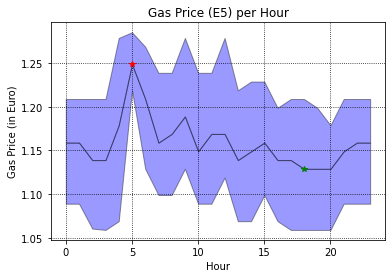

In [29]:
df_hour_summary = compute_quantiles(metric, metric.index.hour)

fig, ax = plot_gas_prices(df_hour_summary[gas_type], title_post_fix='per Hour')
ax.set_xlabel('Hour');
#plt.savefig(f'{metric}.png', dpi=300)

argmin: 3
argmax: 5


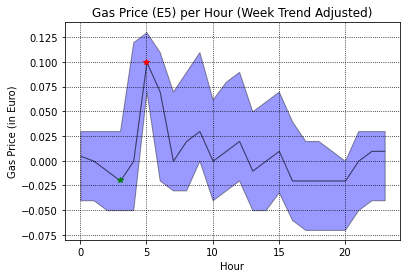

In [30]:
metric_without_weekly_trend = adjust_trend(metric, week_grouper)
df_hour_summary = compute_quantiles(metric_without_weekly_trend, metric_without_weekly_trend.index.hour)

fig, ax = plot_gas_prices(df_hour_summary[gas_type], title_post_fix='per Hour (Week Trend Adjusted)')
ax.set_xlabel('Hour');
#plt.savefig(f'{metric}.png', dpi=300)

argmin: 20
argmax: 5


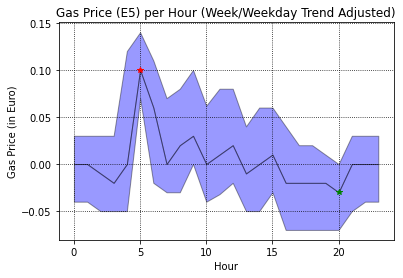

In [31]:
metric_without_weekly_and_hourly_trend = adjust_trend(metric_without_weekly_trend, metric_without_weekly_trend.index.dayofweek)
df_hour_summary = compute_quantiles(metric_without_weekly_and_hourly_trend, metric_without_weekly_and_hourly_trend.index.hour)

fig, ax = plot_gas_prices(df_hour_summary[gas_type], title_post_fix='per Hour (Week/Weekday Trend Adjusted)')
ax.set_xlabel('Hour');
#plt.savefig(f'{metric}.png', dpi=300)

## Gas Prices per Hour per Weekday

argmin: 67
argmax: 29


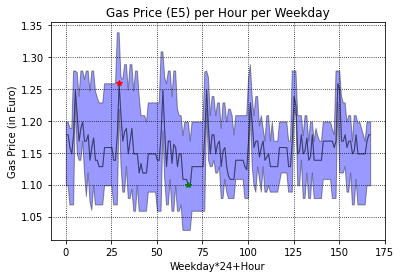

In [32]:
df_hour_weekday_summary = compute_quantiles(metric, metric.index.weekday*24+metric.index.hour)

fig, ax = plot_gas_prices(df_hour_weekday_summary[gas_type], title_post_fix='per Hour per Weekday')
ax.set_xlabel('Weekday*24+Hour');
#plt.savefig(f'{metric}.png', dpi=300)

In [33]:
x = 67
print(x // 24) # day
print(x % 24) # hour

2
19


argmin: 66
argmax: 5


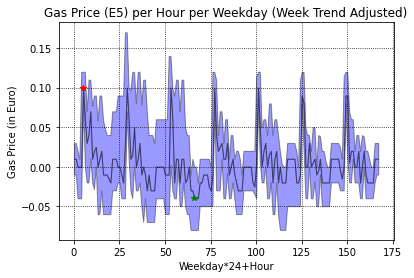

In [34]:
metric_without_weekly_trend = adjust_trend(metric, week_grouper)

df_hour_weekday_summary = compute_quantiles(metric_without_weekly_trend, metric_without_weekly_trend.index.weekday*24+metric_without_weekly_trend.index.hour)

fig, ax = plot_gas_prices(df_hour_weekday_summary[gas_type], title_post_fix='per Hour per Weekday (Week Trend Adjusted)')
ax.set_xlabel('Weekday*24+Hour');
#plt.savefig(f'{metric}.png', dpi=300)

In [35]:
x = 66
print(x // 24) # day
print(x % 24) # hour

2
18
